In [1]:
import numpy as np
import matplotlib.pyplot as plt

from timescales.sim import sim_spikes_synaptic
from neurodsp.sim import sim_action_potential

from timescales.fit import ACF, fit_psd, convert_knee_val
from neurodsp.spectral import compute_spectrum

### Using Highpass vs Binning Spikes

This notebook explores if the highpass of a signal, from which spike counts are determined from, contains the simulated timescale.

1. Simulate spike times with a given timescale
2. Convolve spike times with a spike waveform
3. Take the signal from step 2 and compute the timescale

The results show the timescales can be recovered from the high-pass, and should be preferred over binning spikes, since binning reduces the duration of the timeseries and leads to bias resulting from finite/short duration signals.

In [2]:
# Simulate spike times
np.random.seed(0)
n_seconds = 10
fs = 12000
n_neurons = 1
tau = convert_knee_val(10)

probs, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=n_neurons, return_sum=False)

spikes = spikes[0]
times = np.arange(0, n_seconds, 1/fs)

# Simulate spike waveform
n_samples = 50
centers = [.3, .5, .7]
stds = [.08, .1, .08]
alphas = [.1, 0, .1]
heights = [.2, -.8, .3]
spike_wave = sim_action_potential(1, n_samples, centers, stds, alphas, heights)

# Convolve spike waveform
spike_ts = np.convolve(spikes, spike_wave, mode='valid')

### Simulation

The spikes times (first plot) are convolved with the simulated spike waveform (second plot) to produce a simulated high-pass timeseries that contains spikes.

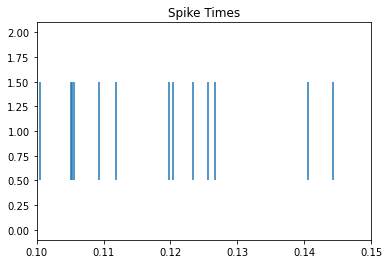

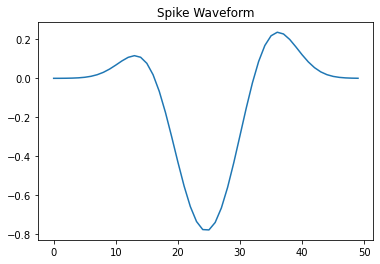

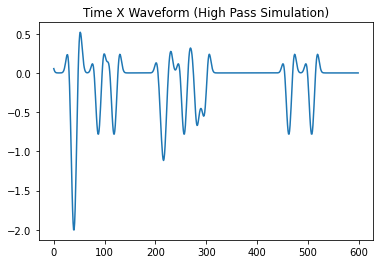

In [3]:
plt.figure(0)
t_bounds = [.1, .15]
plt.title('Spike Times')
plt.eventplot(times[spikes])
plt.xlim(*t_bounds)

plt.figure(1)
plt.title('Spike Waveform')
plt.plot(spike_wave);

plt.figure(2)
plt.title('Time X Waveform (High Pass Simulation)')
plt.plot(spike_ts[int(fs * t_bounds[0]):int(fs * t_bounds[1])]);

### ACF

The simulated high-pass time series contains the same timescale as what was simulated in the spike probability array.

Ground Truth:  0.015915494309189534
Fit Tau     :  0.016078855528763987


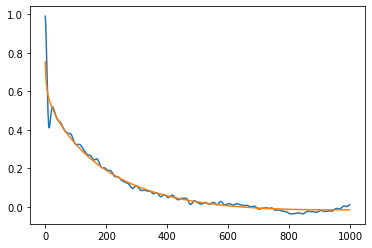

In [4]:
acf = ACF()
acf.compute_acf(spike_ts, fs, nlags=1000)
acf.fit_cos()

plt.plot(acf.corrs)
plt.plot(acf.corrs_fit)

print('Ground Truth: ', tau)
print('Fit Tau     : ', acf.params[0]) 

### SpecParam

The shape of the simulated high-pass contains a similar shape, with reduced total power, to the simulated spike probability PSD.

There is some error do to the finite duration bias, but the timescales reported below represent the 10 hz simulated tau, and the fit represents a 9.3 Hz knee.

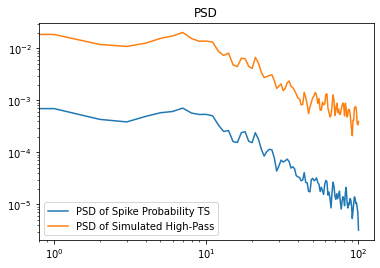

In [5]:
freqs_spikes, powers_spikes = compute_spectrum(spike_ts, fs, f_range=(0, 100))
freqs_probs, powers_probs = compute_spectrum(probs, fs, f_range=(0, 100))

plt.title('PSD')
plt.loglog(freqs_probs, powers_probs, label='PSD of Spike Probability TS')
plt.loglog(freqs_spikes, powers_spikes, label='PSD of Simulated High-Pass')
plt.legend();

In [6]:
fm, knee_freq, tau_psd = fit_psd(freqs_spikes, powers_spikes, (0, 100))

print('Ground Truth: ', tau)
print('Fit Tau     : ', tau_psd) 

Ground Truth:  0.015915494309189534
Fit Tau     :  0.017146459733789605
